In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Skin Cancer Detection -Melanoma Detection Assignment

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

## 1. Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.simplefilter("ignore")

2024-03-20 15:46:11.023108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 15:46:11.023218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 15:46:11.184350: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Data Import

In [2]:
data_dir_train = pathlib.Path("/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test= pathlib.Path("/kaggle/input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
img_train_count = len(list(data_dir_train.glob('*/*.jpg')))
print(img_train_count)
img_test_count = len(list(data_dir_test.glob('*/*.jpg')))
print(img_test_count)

2239
118


### 2.1 Dataset creation using keras

In [4]:
batchSize = 32
img_width=180
img_height=180

In [5]:
df_train = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,
                                                               subset='training',
                                                               image_size=(img_height,img_width),
                                                              batch_size=batchSize)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
df_val = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,seed=123,validation_split=0.2,
                                                               subset='validation',
                                                               image_size=(img_height,img_width),
                                                              batch_size=batchSize)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
train_class_names = df_train.class_names
print(train_class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### 2.2 Data Visualization

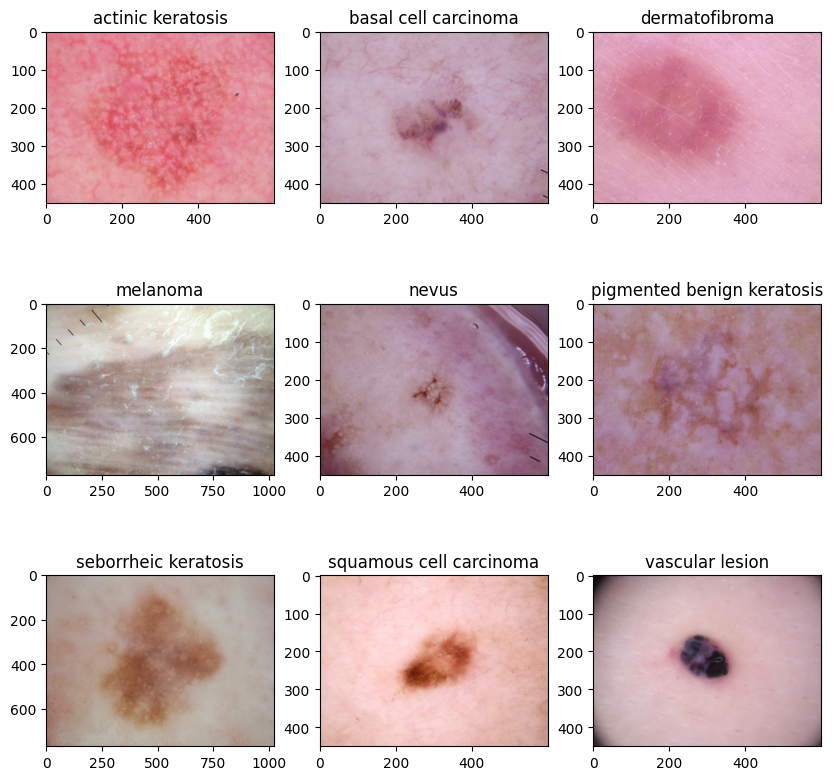

In [8]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(train_class_names[i]+'/*.jpg'))[1]))
  plt.title(train_class_names[i])
  plt.imshow(image)

### 2.3 Data Agumentation

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = df_train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = df_val.cache().prefetch(buffer_size=AUTOTUNE)

### 2.4 Data visualization after data augementation

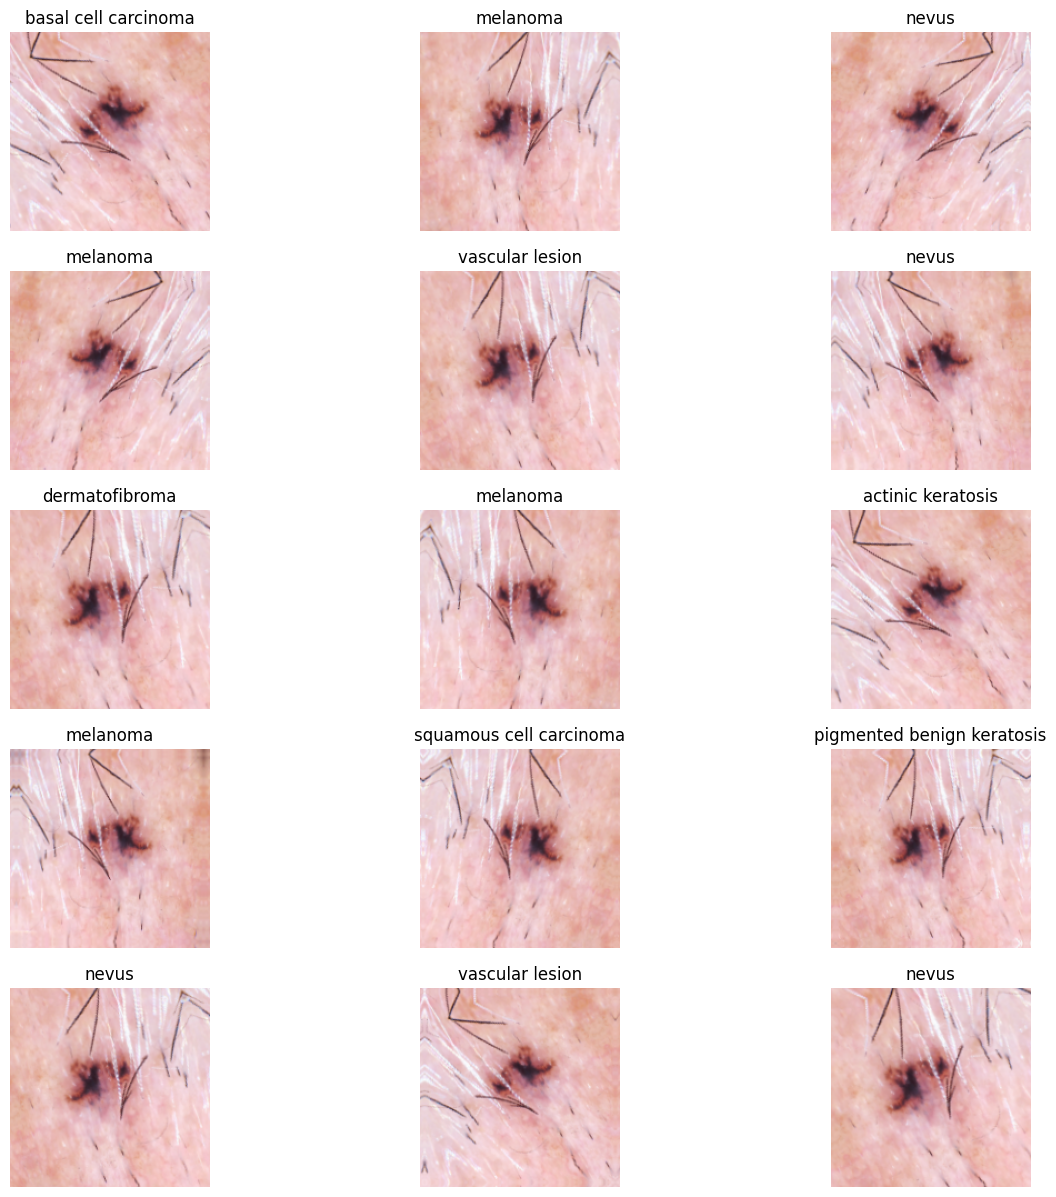

In [11]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(train_class_names[label[i]])
        plt.axis("off")

## 3. Model Creation

In [12]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation
num_classes = 9
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes, activation = "softmax"))

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 45, 45, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 22, 22, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,199,945 (4.58 MB)

 Trainable params: 1,199,945 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-03-20 15:47:32.473983: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,180,180]{3,2,1,0}, f32[32,32,180,180]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-20 15:47:32.512346: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.038501101s
Trying algorithm eng0{} for conv (f32[32,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,180,180]{3,2,1,0}, f32[32,32,180,180]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-03-20 15:47:34.383979: E external/

 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.1181 - loss: 2.2459  

I0000 00:00:1710949658.225440     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.1797 - loss: 2.1411 - val_accuracy: 0.1924 - val_loss: 2.0382
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2046 - loss: 2.0287 - val_accuracy: 0.2058 - val_loss: 2.0443
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2138 - loss: 2.0167 - val_accuracy: 0.2349 - val_loss: 2.0104
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2100 - loss: 1.9860 - val_accuracy: 0.2550 - val_loss: 1.9629
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2397 - loss: 1.9950 - val_accuracy: 0.2349 - val_loss: 1.9789
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2482 - loss: 1.9928 - val_accuracy: 0.2058 - val_loss: 2.0362
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2155 - loss: 2.0084 - val_accuracy: 0.1924 - val_loss: 2.0296
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.2120 - loss: 2.0020 - val_accuracy: 0.2058 - val_loss: 

### 3.1 Visualization

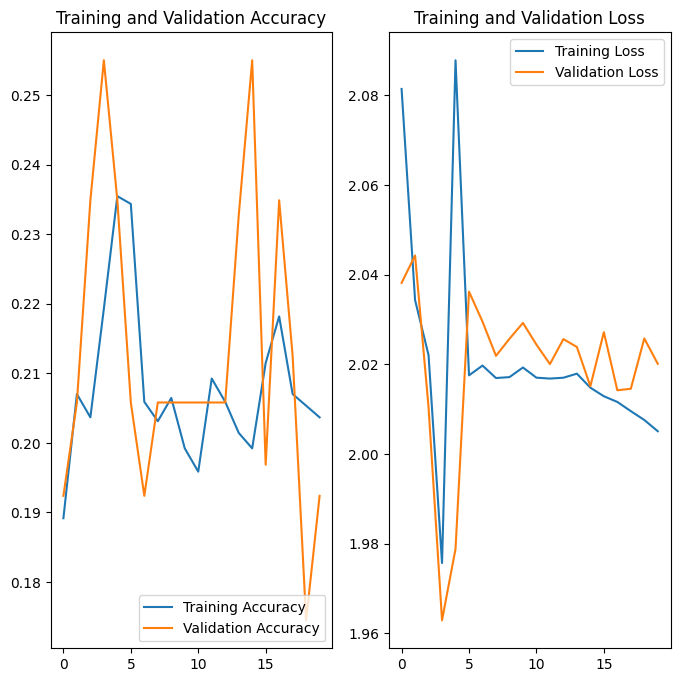

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

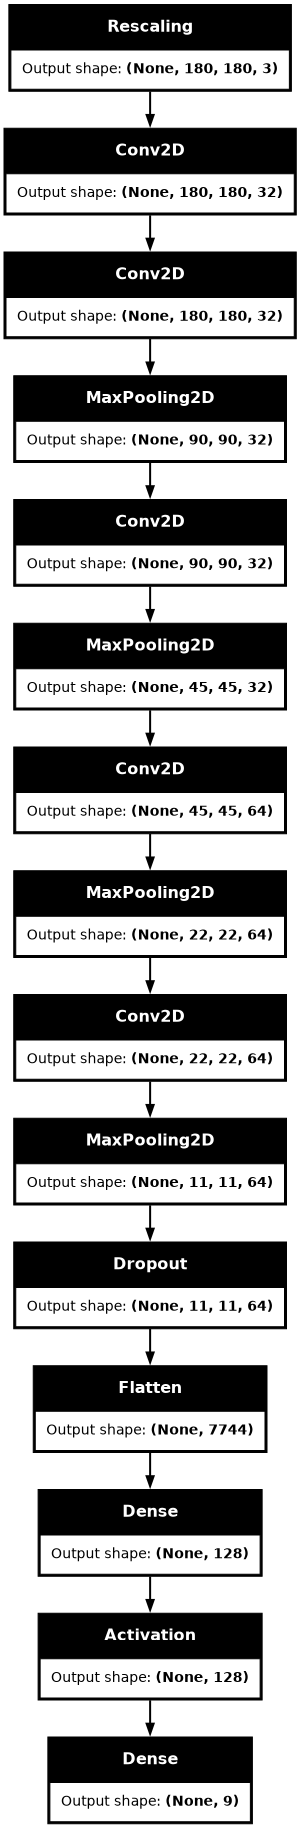

In [18]:
tf.keras.utils.plot_model(model = model , rankdir="TB", dpi=72, show_shapes=True)

In [19]:
##
path_list=[]
lesion_list=[]
for i in train_class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
1,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
2,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
3,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
4,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
...,...,...
2234,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion
2235,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion
2236,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion
2237,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion


In [20]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
1,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
2,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
3,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
4,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
...,...,...
2234,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion
2235,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion
2236,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion
2237,/kaggle/input/skin-cancer-detection/Skin cance...,vascular lesion


<BarContainer object of 9 artists>

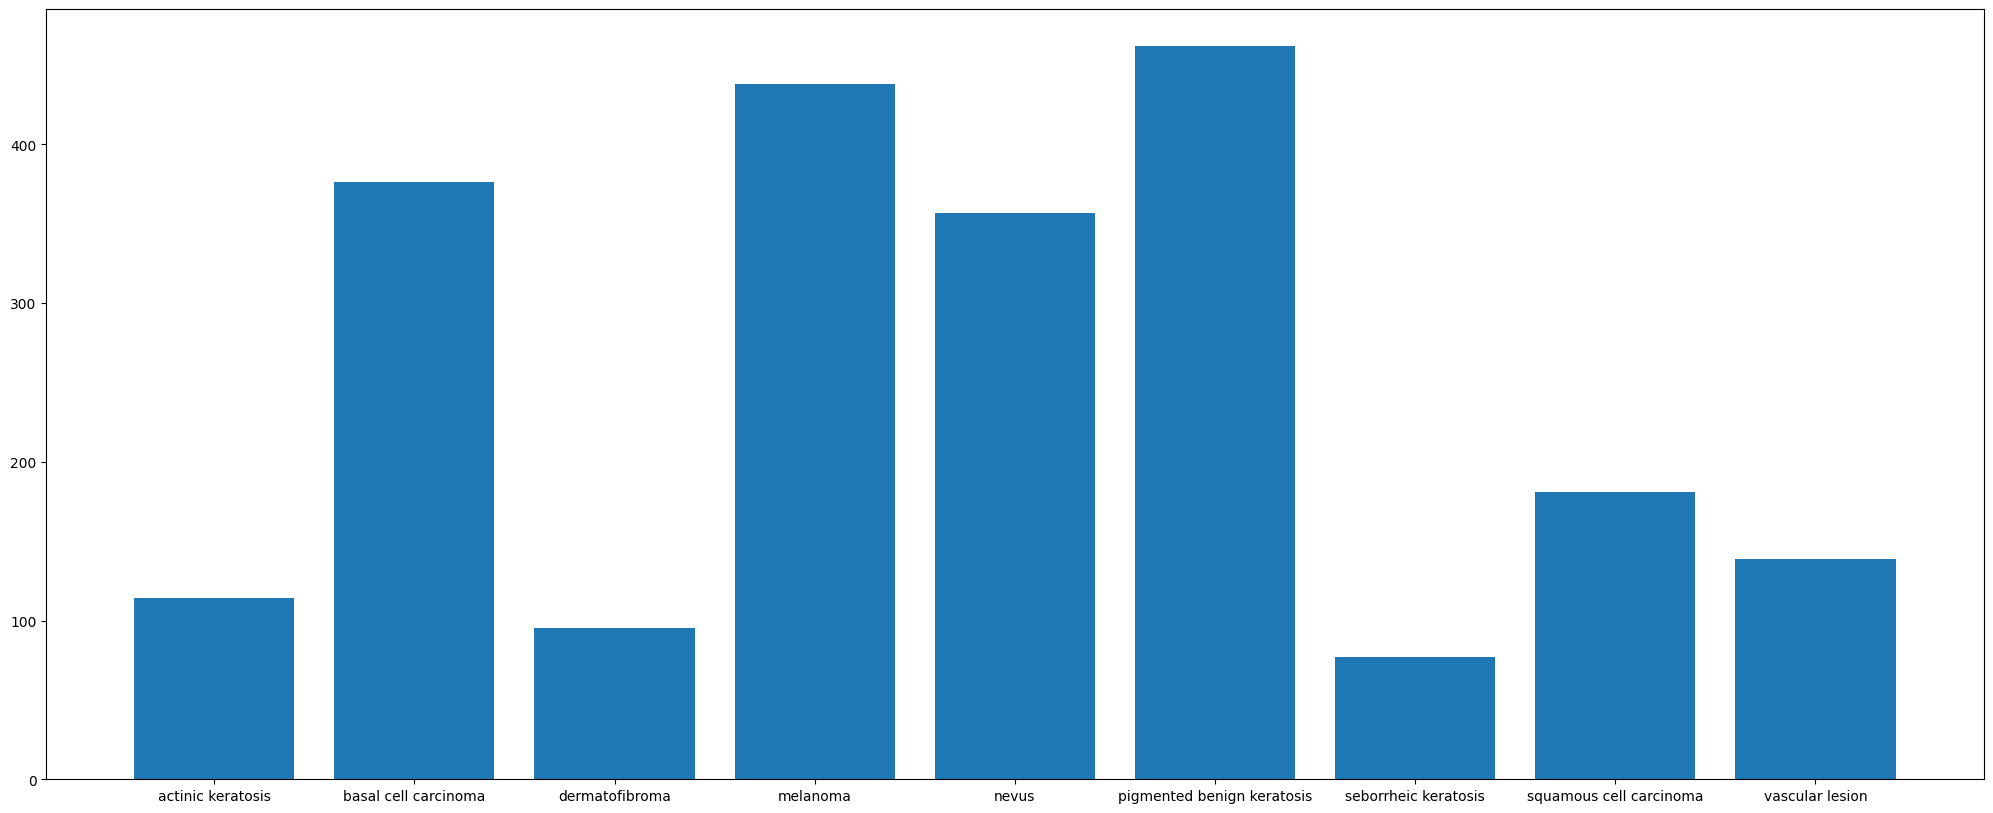

In [21]:
count=[]
for i in train_class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(train_class_names,count)

Rectify the class imbalance¶
Python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.
To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [22]:
train_class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [23]:
pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [24]:
## We are adding 500 samples per class to make sure that none of the classes are sparse.
import Augmentor
path_to_training_dataset="../input/skin-cancer-detection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in train_class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5EBC495420>: 100%|██████████| 500/500 [00:06<00:00, 74.64 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5EBC2FAD40>: 100%|██████████| 500/500 [00:05<00:00, 83.76 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5EBC4EF280>: 100%|██████████| 500/500 [00:06<00:00, 82.77 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D5EBC3BF490>: 100%|██████████| 500/500 [00:32<00:00, 15.17 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D5EF02A97B0>: 100%|██████████| 500/500 [00:33<00:00, 15.13 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D5EBC2F80A0>: 100%|██████████| 500/500 [00:06<00:00, 80.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D5F183082E0>: 100%|██████████| 500/500 [00:15<00:00, 32.34 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5F182E5990>: 100%|██████████| 500/500 [00:05<00:00, 83.48 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D5EF04E94E0>: 100%|██████████| 500/500 [00:06<00:00, 80.66 Samples/s]                  


In [25]:
data_dir_train_aug = pathlib.Path("/kaggle/working/")
image_count_train_aug = len(list(data_dir_train_aug.glob('*/output/*.jpg')))
print(image_count_train_aug)

4500


In [26]:
for i in train_class_names:

    for j in data_dir_train_aug.glob(i+'/output/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
aug_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
aug_df

,Path,Label
0,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
1,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
2,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
3,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
4,/kaggle/input/skin-cancer-detection/Skin cance...,actinic keratosis
...,...,...
6734,/kaggle/working/vascular lesion/output/vascula...,vascular lesion
6735,/kaggle/working/vascular lesion/output/vascula...,vascular lesion
6736,/kaggle/working/vascular lesion/output/vascula...,vascular lesion
6737,/kaggle/working/vascular lesion/output/vascula...,vascular lesion


In [27]:
aug_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

## 4 Training

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=32)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


In [29]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=32)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


In [31]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,Activation
num_classes = 9
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 180, 180, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 90, 90, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 45, 45, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,148,009 (15.82 MB)

 Trainable params: 4,148,009 (15.82 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
epochs =30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.0988 - loss: 2.2497 - val_accuracy: 0.1089 - val_loss: 2.1971
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1112 - loss: 2.1974 - val_accuracy: 0.1056 - val_loss: 2.1974
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1179 - loss: 2.1971 - val_accuracy: 0.1022 - val_loss: 2.1969
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1164 - loss: 2.1968 - val_accuracy: 0.1056 - val_loss: 2.1974
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1066 - loss: 2.1974 - val_accuracy: 0.1056 - val_loss: 2.1975
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1119 - loss: 2.1972 - val_accuracy: 0.1011 - val_loss: 2.1975
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1083 - loss: 2.1973 - val_accuracy: 0.1011 - val_loss: 2.1975
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.1060 - loss: 2.1970 - val_ac

### 4.1 Visualization

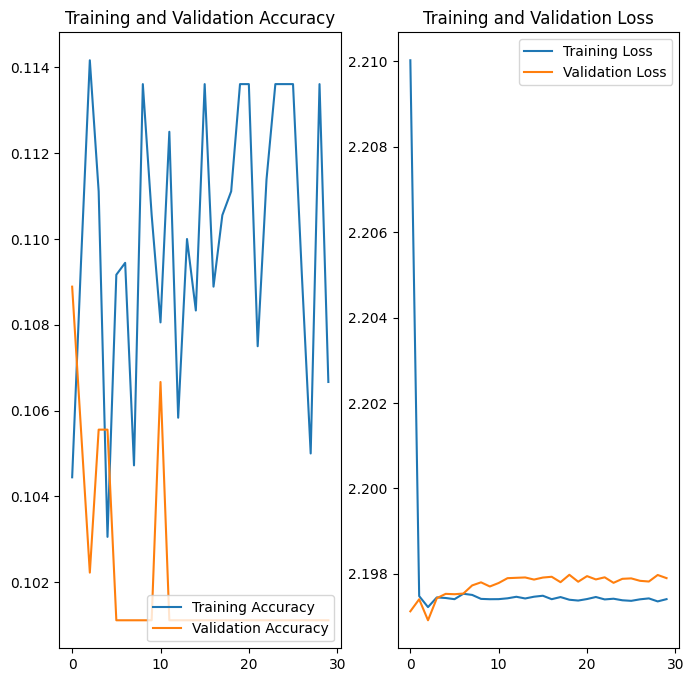

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### 4.2 Model with Data Augmentation and using Augmentor dataset

In [38]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.RandomFlip(mode="horizontal",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.1),
                             layers.RandomZoom(0.1)
])

In [41]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
model = data_augmentation
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))


In [43]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 180, 180, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 180, 180, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,992,121 (15.23 MB)

 Trainable params: 3,992,121 (15.23 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
epochs = 50
# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


2024-03-20 16:03:48.685556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1151 - loss: 2.1994 - val_accuracy: 0.1144 - val_loss: 2.1974
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1056 - loss: 2.1973 - val_accuracy: 0.1011 - val_loss: 2.1974
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1196 - loss: 2.1973 - val_accuracy: 0.1011 - val_loss: 2.1975
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1180 - loss: 2.1973 - val_accuracy: 0.1011 - val_loss: 2.1975
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1122 - loss: 2.1973 - val_accuracy: 0.1011 - val_loss: 2.1977
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1032 - loss: 2.1973 - val_accuracy: 0.1011 - val_loss: 2.1976
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1173 - loss: 2.1971 - val_accuracy: 0.1011 - val_loss: 2.1977
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.1060 - loss: 2.1974 - val_accuracy: 0.101

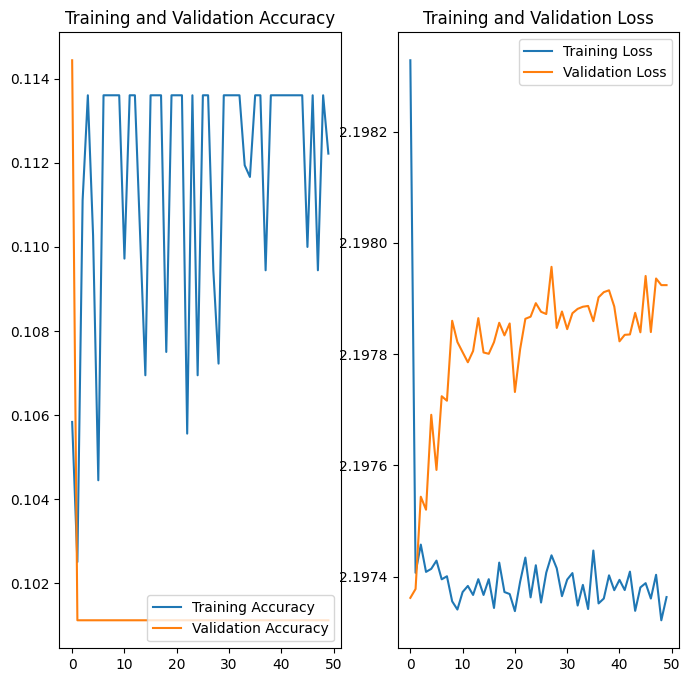

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [47]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batchSize)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 118 files belonging to 9 classes.


# 5. Model Evaluation

Predictions:
 [1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1
 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1
 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0
 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0
 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1
 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0
 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1
 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0]
Labels:
 [0 3 7 7 2 3 3 2 5 0 8 2 1 1 1 7 7 5 5 5 4 4 2 0 3 7 3 1 5 2 4 5]


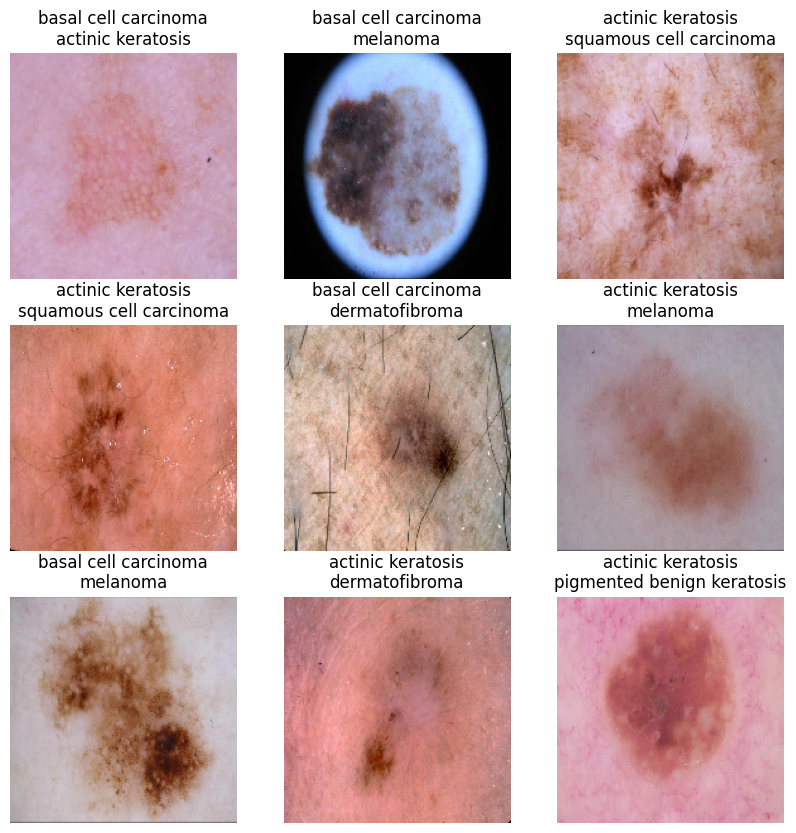

In [48]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(train_class_names[predictions[i]] + "\n" + train_class_names[label_batch[i]])
    plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


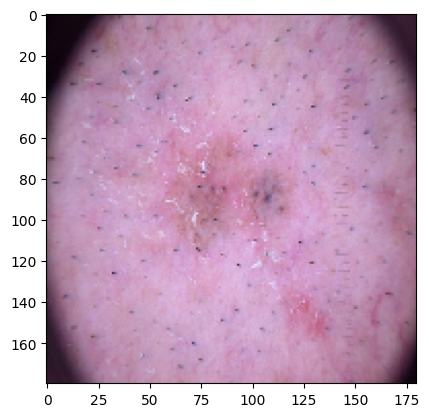

In [49]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, train_class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = tf.keras.preprocessing.image.load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = train_class_names[pred]
print("Actual Class "+ train_class_names[1] +'\n'+ "Predictive Class "+pred_class )